In [1]:
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import random
import threading

In [2]:
#hyper parameters
t_max = 10
gamma = 0.99
learning_rate = 0.001
beta = 0.1

seed = 0

np.random.seed(seed)
torch.manual_seed(seed)


In [3]:
actions = [ -2 + 0.4*i for i in range(11)]

print(actions)

[-2.0, -1.6, -1.2, -0.7999999999999998, -0.3999999999999999, 0.0, 0.40000000000000036, 0.8000000000000003, 1.2000000000000002, 1.6, 2.0]


In [4]:
class policy_net(nn.Module):
    def __init__(self, input_feature, num_action):
        super(policy_net,self).__init__()
        self.linear1 = nn.Linear(in_features = input_feature, out_features = 128)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(in_features = 128, out_features = num_action)
        

        
    def forward(self,x):
        x = self.activation1(self.linear1(x))
        x = self.linear2(x)
        policy = F.softmax(x,dim=0)
        return policy
    
class value_net(nn.Module):
    def __init__(self, input_feature):
        super(value_net,self).__init__()
        self.linear1 = nn.Linear(in_features = input_feature, out_features = 128)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(in_features = 128, out_features = 1)

        
    def forward(self,x):
        x = self.activation1(self.linear1(x))
        x = self.linear2(x)
        return x
    
    
    

In [5]:

def get_action_idx(num_action, policy):
    return np.random.choice(num_action, 1, p=policy.detach().numpy()).item()



In [6]:
#multihtread
p_net_shared = policy_net(3,11)
v_net_shared = value_net(3)
np.random.seed(seed)
torch.manual_seed(seed)

reward_plot = [0 for i in range(5000)]

def training(idx):
    t_max = 5
    gamma = 0.9
    learning_rate = 0.001
    beta = 0
    num_action = 11
    step = 0
    state = []
    
    env = gym.make('Pendulum-v0')

    global p_net_shared
    global v_net_shared
    p_optimizer = optim.Adam(p_net_shared.parameters(), lr=learning_rate)
    v_optimizer = optim.Adam(v_net_shared.parameters(), lr=learning_rate)
    global reward_plot
    
    for iteration in range(5000):
        done = False
        observation = env.reset()
        state = observation
        
        p_net = policy_net(3,num_action)
        v_net = value_net(3)
    
        p_net.zero_grad()
        v_net.zero_grad()
        
        t_update = 0
        #beta -= 0.0003
        #learning_rate -= 0.0009/2000
        if(iteration>2000):
            learning_rate = 0.0001
        if(beta<=0):
            beta = 0
        reward_stack = []
        prob_stack = []
        value_stack = []
        entropy = 0
        reward_sum = 0
        policy_loss_sum=0
        value_loss_sum = 0
        entropy_sum = 0
        for t in range(10000):

            step = step+1

            policy= p_net(torch.Tensor(state))
            value = v_net(torch.Tensor(state))
            action_idx = get_action_idx(num_action, policy)
            action = -2 + 0.4 * action_idx
            
            next_state , reward, done, info = env.step([action])
            reward /= 16.2736044
            reward_sum += reward
            t_update += 1

            reward_stack.append(reward)
            value_stack.append(value)
            prob_stack.append(policy[action_idx])
            
            entropy += -torch.sum(policy * torch.log(torch.clamp(policy,min=1e-6)))

            if(t_update >= t_max or done):
                R = v_net(torch.Tensor(next_state))
                policy_loss = 0
                value_loss = 0
                

                for i in range(t_update):
                    R = R*gamma + reward_stack.pop()
                    value_temp = value_stack.pop()
                    policy_loss += -torch.log(torch.clamp(prob_stack.pop(),min=1e-6)) * (R-value_temp).detach()
                    value_loss += (R-value_temp) * (R-value_temp)
                    
                entropy = -entropy * beta
                policy_loss = policy_loss + entropy 
                policy_loss = policy_loss / t_max
                value_loss = value_loss /t_max
                
                policy_loss.backward(retain_graph=True)
                value_loss.backward()
                policy_loss_sum += policy_loss.detach().numpy()
                value_loss_sum += value_loss.detach().numpy()
                update = 1
                for p_param , s_p_param , v_param , s_v_param in zip(p_net.parameters(), p_net_shared.parameters(), v_net.parameters(), v_net_shared.parameters()):
                    if(s_p_param.grad is not None and  s_p_param.grad.sum().detach().numpy() != 0):
                        update = 0
                        break
                    if(s_v_param.grad is not None and  s_v_param.grad.sum().detach().numpy() !=0):
                        update = 0
                        break
                    s_p_param._grad = p_param.grad.detach()
                    s_v_param._grad = v_param.grad.detach()
                    if((s_p_param != s_p_param).any()):
                        print("explode !!!! ")
                    
                if(update):
                    p_optimizer.step()
                    v_optimizer.step()
                    p_net_shared.zero_grad()
                    v_net_shared.zero_grad()
                
                p_net = policy_net(3,num_action)
                v_net = value_net(3)    

                p_net.load_state_dict(p_net_shared.state_dict())
                v_net.load_state_dict(v_net_shared.state_dict())
                R=0
                entropy = 0
                t_update = 0
            if(done):
                break

            #env.render()
            state = next_state[:]
        reward_plot[iteration] += reward_sum
        if(iteration%10 ==0):
            print(policy_loss_sum)
            print(value_loss_sum)
            print("training idx {} actor true_reward at iteration {} : {}".format(idx,iteration, reward_sum))
            print(step)
            beta = beta * 0.99
th1 = threading.Thread(target = training , args = (1,))
'''th2 = threading.Thread(target = training , args = (2,))
th3 = threading.Thread(target = training , args = (3,))
''''''th4 = threading.Thread(target = training , args = (4,))'''
th1.start()
'''th2.start()
th3.start()
''''''th4.start()'''

th1.join()
'''th2.join()
th3.join()
''''''th4.join()'''

print("finish")

/home/wooseoko/anaconda3/envs/spinningup/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[-120.23541]
[74.82909]
training idx 1 actor true_reward at iteration 0 : -109.7688627337305
200
[-5.59455]
[2.14592]
training idx 1 actor true_reward at iteration 10 : -92.7844598143541
2200
[-2.4112327]
[1.9258865]
training idx 1 actor true_reward at iteration 20 : -78.2258937180874
4200
[-5.5774627]
[4.2700057]
training idx 1 actor true_reward at iteration 30 : -81.2975692145788
6200
[-3.9387782]
[2.881576]
training idx 1 actor true_reward at iteration 40 : -91.86499499948515
8200
[-0.8622006]
[0.47573143]
training idx 1 actor true_reward at iteration 50 : -69.42667164829895
10200
[3.0020645]
[2.9959817]
training idx 1 actor true_reward at iteration 60 : -67.18857612655854
12200
[-1.3769902]
[0.99978715]
training idx 1 actor true_reward at iteration 70 : -55.60326527180667
14200
[3.5162537]
[1.174151]
training idx 1 actor true_reward at iteration 80 : -44.7120516913962
16200
[0.34885114]
[0.51567125]
training idx 1 actor true_reward at iteration 90 : -47.86085090226253
18200
[0.6880

[-2.644716]
[1.9728628]
training idx 1 actor true_reward at iteration 810 : -32.78570402969326
162200
[-3.2463765]
[2.4528115]
training idx 1 actor true_reward at iteration 820 : -24.00007406696384
164200
[-2.1142135]
[1.0294753]
training idx 1 actor true_reward at iteration 830 : -16.152335343133537
166200
[0.16035736]
[0.620478]
training idx 1 actor true_reward at iteration 840 : -15.777837101233208
168200
[-0.86317414]
[0.17950767]
training idx 1 actor true_reward at iteration 850 : -7.55578898076737
170200
[-0.14963962]
[0.07440694]
training idx 1 actor true_reward at iteration 860 : -8.049708973100504
172200
[-3.843492]
[2.7144094]
training idx 1 actor true_reward at iteration 870 : -27.92091291915713
174200
[-1.4918997]
[0.6504072]
training idx 1 actor true_reward at iteration 880 : -16.160298779737623
176200
[0.32398802]
[0.02008361]
training idx 1 actor true_reward at iteration 890 : -0.12381444378862493
178200
[-0.07439747]
[0.8293136]
training idx 1 actor true_reward at itera

KeyboardInterrupt: 

Text(0.5, 1.0, 'reward')

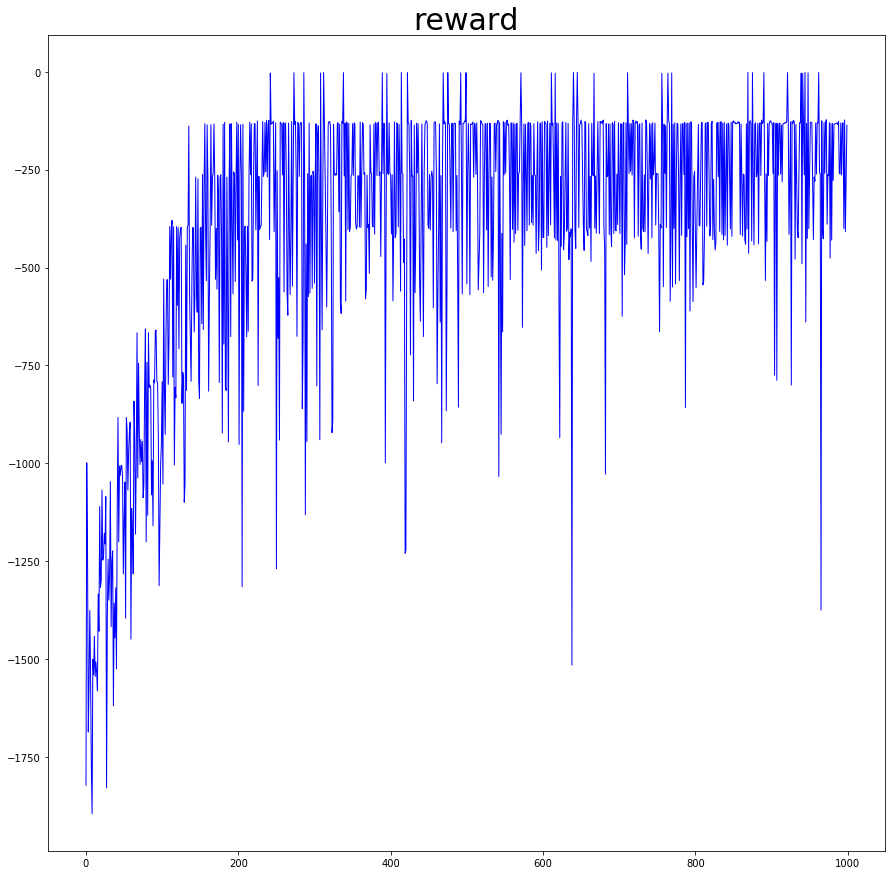

[-0.21231468]
[0.01825362]
training idx 1 actor true_reward at iteration 3020 : -0.13523689620080734
604200
[0.5079665]
[0.26852548]
training idx 1 actor true_reward at iteration 3030 : -7.926451653199387
606200
[-1.1067978]
[0.352631]
training idx 1 actor true_reward at iteration 3040 : -8.05384644820612
608200
[-2.8655076]
[2.872307]
training idx 1 actor true_reward at iteration 3050 : -23.903946160686967
610200
[0.17656781]
[0.10662908]
training idx 1 actor true_reward at iteration 3060 : -7.867874929000841
612200
[-0.9243566]
[0.38806376]
training idx 1 actor true_reward at iteration 3070 : -7.4800470420937994
614200
[-0.15276232]
[0.00725086]
training idx 1 actor true_reward at iteration 3080 : -0.12396757034276011
616200
[-3.76627]
[5.133818]
training idx 1 actor true_reward at iteration 3090 : -60.787027613070066
618200
[-0.8788029]
[0.4306022]
training idx 1 actor true_reward at iteration 3100 : -7.861561835495624
620200
[-0.47381997]
[0.1857948]
training idx 1 actor true_rewar

In [8]:
reward_np = np.array(reward_plot[:1000]) * 16.6
fig, axe = plt.subplots(1, figsize = (15,15))
axe.plot(list(range(len(reward_np))),reward_np, lw = 1, label = 'reward', color = 'blue')
axe.set_title('reward', fontsize = 30)


In [11]:
#test
state = []
env = gym.make('Pendulum-v0')
done = False
reward_sum=0
observation = env.reset()
state = observation
num_action = 11

for t in range(10000):
    env.render()
    
    policy= p_net_shared(torch.Tensor(state))
    value = v_net_shared(torch.Tensor(state))

    action = get_action_idx(num_action, policy)
    action = -2 + 0.4 * action_idx
    obs , reward, done, info = env.step([action])
    
    
    reward_sum = reward_sum + reward
    state=obs
    if done:
        break
    
print("reward {}".format(reward_sum))

ValueError: probabilities contain NaN